In [213]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from overcomplete.sae import TopKSAE, train_sae
import pandas as pd

In [214]:
train_path = "./logs/activation.pt"

In [215]:
ckpt = torch.load(train_path)
fc1 = ckpt["fc1"]
fc1_activations = ckpt["fc1_activations"]
labels = ckpt["labels"]

/tmp/ipykernel_70114/3355228409.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(train_path)


In [160]:
fc1

tensor([[ 8.1721,  8.6419,  4.6956,  ..., -2.0162,  5.1585, -1.7850],
        [ 2.0573,  1.2542,  3.3626,  ..., -1.7315,  1.5306, -1.3794],
        [ 0.7835,  6.8893,  6.8415,  ..., -2.4338,  1.2805, -0.9816],
        ...,
        [ 2.4755,  2.5993,  3.3091,  ..., -1.8202,  4.5090, -1.5915],
        [ 5.7298,  4.3320,  4.6720,  ..., -2.2668,  2.5755, -1.8052],
        [ 2.5707, 11.7011,  6.1637,  ..., -2.7598,  1.4774, -2.0934]],
       requires_grad=True)

In [161]:
fc1_activations

tensor([[ 8.1721,  8.6419,  4.6956,  ...,  0.0000,  5.1585,  0.0000],
        [ 2.0573,  1.2542,  3.3626,  ...,  0.0000,  1.5306,  0.0000],
        [ 0.7835,  6.8893,  6.8415,  ...,  0.0000,  1.2805,  0.0000],
        ...,
        [ 2.4755,  2.5993,  3.3091,  ...,  0.0000,  4.5090,  0.0000],
        [ 5.7298,  4.3320,  4.6720,  ...,  0.0000,  2.5755,  0.0000],
        [ 2.5707, 11.7011,  6.1637,  ...,  0.0000,  1.4774,  0.0000]],
       requires_grad=True)

In [216]:
dataloader = torch.utils.data.DataLoader(TensorDataset(fc1), batch_size=1024, shuffle=True)

In [80]:
print(f"Shape: fc1: {fc1.shape}, fc1_activations: {fc1_activations.shape}, labels: {labels.shape}")

Shape: fc1: torch.Size([60000, 128]), fc1_activations: torch.Size([60000, 128]), labels: torch.Size([60000])


In [217]:
sae = TopKSAE(fc1.shape[-1], nb_concepts=256, top_k=12, device='cuda')

dataloader = torch.utils.data.DataLoader(TensorDataset(fc1), batch_size=1024, shuffle=True)
optimizer = torch.optim.Adam(sae.parameters(), lr=5e-4)

def criterion(x, x_hat, pre_codes, codes, dictionary):
  mse = (x - x_hat).square().mean()
  return mse

logs = train_sae(sae, dataloader, criterion, optimizer, nb_epochs=15, device='cuda')

Epoch[1/15], Loss: 13.1782, R2: 0.1077, L0: 12.0000, Dead Features: 57.8%, Time: 30.3010 seconds
Epoch[2/15], Loss: 4.5758, R2: 0.6901, L0: 12.0000, Dead Features: 85.5%, Time: 30.1051 seconds
Epoch[3/15], Loss: 2.3389, R2: 0.8417, L0: 12.0000, Dead Features: 46.1%, Time: 30.2164 seconds
Epoch[4/15], Loss: 1.1595, R2: 0.9215, L0: 12.0000, Dead Features: 55.9%, Time: 32.0902 seconds
Epoch[5/15], Loss: 0.6999, R2: 0.9526, L0: 12.0000, Dead Features: 71.1%, Time: 30.5483 seconds
Epoch[6/15], Loss: 0.5090, R2: 0.9655, L0: 11.9999, Dead Features: 73.8%, Time: 28.7485 seconds
Epoch[7/15], Loss: 0.4134, R2: 0.9720, L0: 11.9997, Dead Features: 75.0%, Time: 28.5045 seconds
Epoch[8/15], Loss: 0.3392, R2: 0.9770, L0: 11.9997, Dead Features: 76.2%, Time: 28.5883 seconds
Epoch[9/15], Loss: 0.2970, R2: 0.9799, L0: 11.9992, Dead Features: 75.4%, Time: 26.9507 seconds
Epoch[10/15], Loss: 0.2702, R2: 0.9817, L0: 11.9991, Dead Features: 78.1%, Time: 28.5628 seconds
Epoch[11/15], Loss: 0.2456, R2: 0.9834

In [181]:
nb_concepts_list = [128, 256, 512]
top_k_ratios = [0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 0.95] 

experiment_logs = []

for nb_concepts in nb_concepts_list:
    for r in top_k_ratios:

        top_k = max(1, int(r * nb_concepts))

        sae = TopKSAE(fc1.shape[-1], nb_concepts=nb_concepts, top_k=top_k, device='cuda')

        optimizer = torch.optim.Adam(sae.parameters(), lr=5e-4)

        logs = train_sae(sae, dataloader, criterion, optimizer, nb_epochs=1, device='cuda')

        experiment_logs.append({
            'top_k': top_k,
            'nb_concepts': nb_concepts,
            'logs': logs
        })

Epoch[1/1], Loss: 20.3761, R2: -0.3797, L0: 2.0000, Dead Features: 76.6%, Time: 33.1193 seconds
Epoch[1/1], Loss: 16.4908, R2: -0.1162, L0: 6.0000, Dead Features: 54.7%, Time: 34.7277 seconds
Epoch[1/1], Loss: 14.1540, R2: 0.0413, L0: 12.0000, Dead Features: 44.5%, Time: 28.7734 seconds
Epoch[1/1], Loss: 11.3857, R2: 0.2288, L0: 25.0000, Dead Features: 28.1%, Time: 32.8972 seconds
Epoch[1/1], Loss: 8.9047, R2: 0.3972, L0: 63.3507, Dead Features: 3.9%, Time: 26.7125 seconds
Epoch[1/1], Loss: 8.8094, R2: 0.4043, L0: 61.2796, Dead Features: 11.7%, Time: 30.2729 seconds
Epoch[1/1], Loss: 8.9899, R2: 0.3919, L0: 65.1484, Dead Features: 7.0%, Time: 26.9139 seconds
Epoch[1/1], Loss: 17.2432, R2: -0.1679, L0: 5.0000, Dead Features: 73.8%, Time: 29.4564 seconds
Epoch[1/1], Loss: 13.8675, R2: 0.0611, L0: 12.0000, Dead Features: 59.0%, Time: 32.5186 seconds
Epoch[1/1], Loss: 11.8030, R2: 0.2000, L0: 25.0000, Dead Features: 33.6%, Time: 31.3845 seconds
Epoch[1/1], Loss: 8.1940, R2: 0.4448, L0: 51.

In [191]:
experiment_logs = torch.load('logs.pt')

/tmp/ipykernel_70114/140958389.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  experiment_logs = torch.load('logs.pt')


In [189]:
torch.save(experiment_logs, "logs.pt")

In [211]:
experiment_logs[0]['logs']['dead_features']

[0.765625,
 0.953125,
 0.96875,
 0.953125,
 0.953125,
 0.9375,
 0.9375,
 0.84375,
 0.890625,
 0.9375,
 0.9453125,
 0.9375,
 0.953125,
 0.953125,
 0.9453125]

In [185]:
experiment_logs = torch.load("logs.pt")

/tmp/ipykernel_70114/104237487.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  experiment_logs = torch.load("logs.pt")


In [198]:
for item in experiment_logs:
    top_k = item['top_k']
    nb_concepts = item['nb_concepts']
    loss = item['logs']
    avg_loss = loss['avg_loss']
    r2 = loss['r2']
    z_sparsity = loss['z_sparsity']
    dead_features = loss['dead_features']

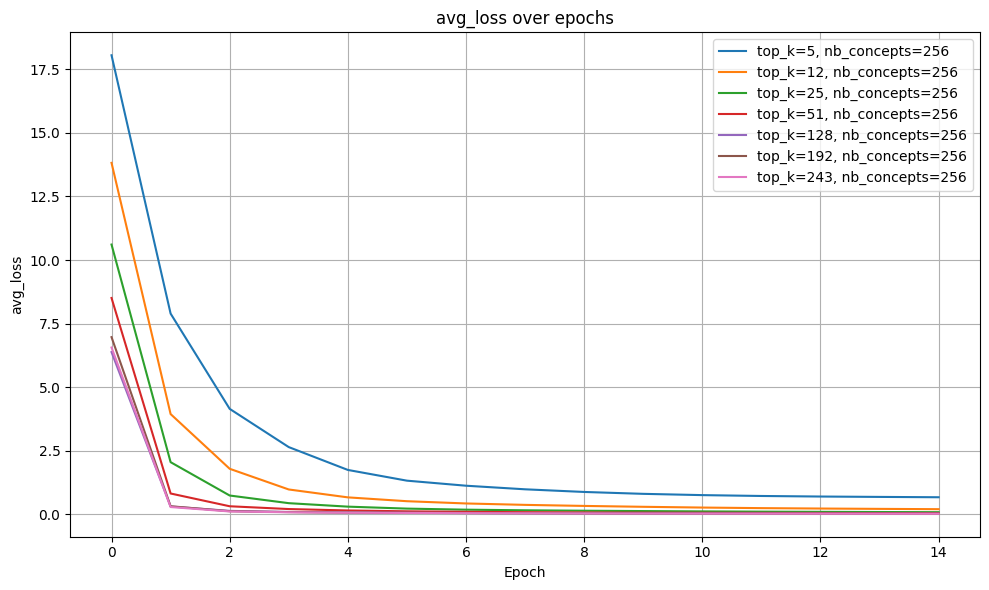

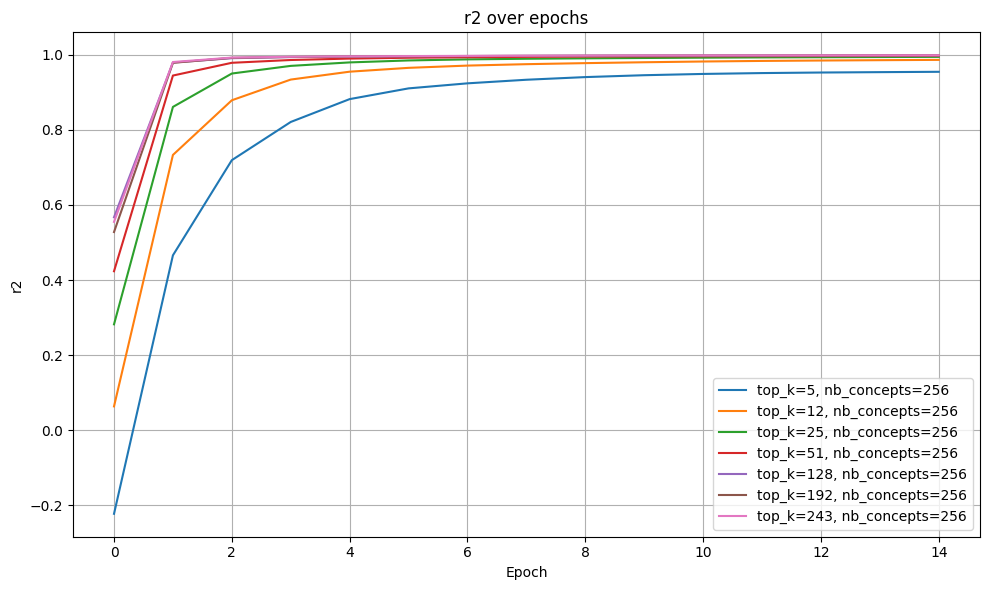

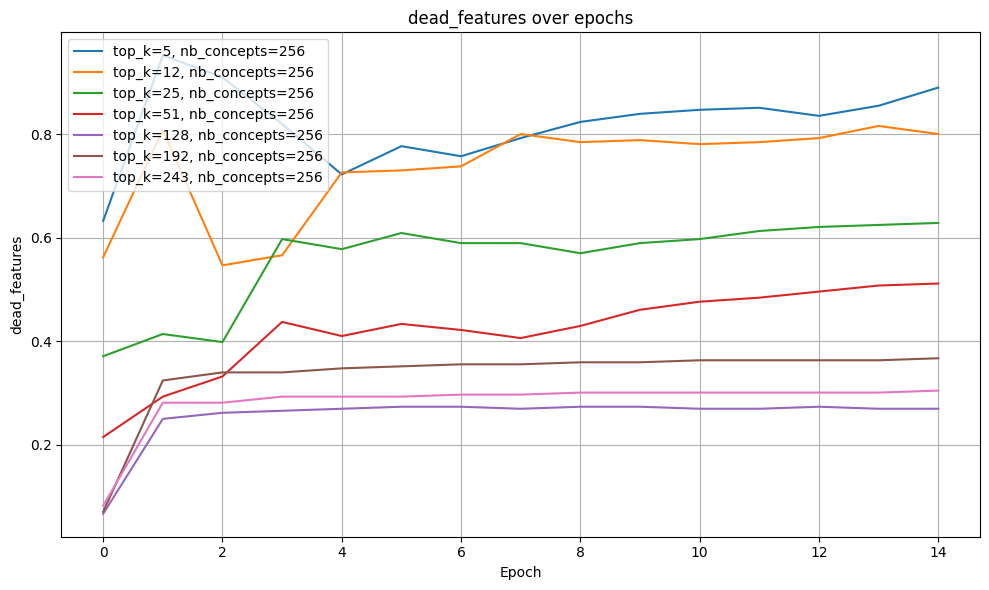

In [212]:
epochs = list(range(15))
results = []
for item in experiment_logs:
    top_k = item['top_k']
    nb_concepts = item['nb_concepts']
    logs = item['logs']
    label = f"top_k={top_k}, nb_concepts={nb_concepts}"

    if nb_concepts != 256:
        continue

    results.append({
        "label": label,
        "avg_loss": logs['avg_loss'][:15],
        "r2": logs['r2'][:15],
        "dead_features": logs['dead_features'][:15]
    })

# Plotting function
def plot_metric(metric_name):
    plt.figure(figsize=(10, 6))
    for result in results:
        plt.plot(epochs, result[metric_name], label=result["label"])
    plt.title(f"{metric_name} over epochs")
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metric("avg_loss")
plot_metric("r2")
plot_metric("dead_features")

In [218]:
sae = sae.eval()

with torch.no_grad():
  pre_codes, codes = sae.encode(fc1.to(device))

In [219]:
codes

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.5755, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [220]:
activations = pre_codes.cpu()

activations_T = activations.T 

max_vals = activations_T.max(dim=1).values
min_vals = activations_T.min(dim=1).values

df_pre = pd.DataFrame({
    'neuron_id': range(activations_T.shape[0]),
    'max_activation': max_vals.numpy(),
    'min_activation': min_vals.numpy()
})

In [221]:
activations = codes.cpu()

activations_T = activations.T 

max_vals = activations_T.max(dim=1).values
min_vals = activations_T.min(dim=1).values

df = pd.DataFrame({
    'neuron_id': range(activations_T.shape[0]),
    'max_activation': max_vals.numpy(),
    'min_activation': min_vals.numpy()
})

In [222]:
df_filter = df[df.max_activation != 0]

In [223]:
df_filter

,neuron_id,max_activation,min_activation
11,11,5.146107,0.000000
17,17,41.514561,0.000000
33,33,20.735649,0.000000
34,34,0.511052,0.000000
39,39,41.945381,0.000000
49,49,47.124245,0.000000
52,52,1.683706,0.000000
55,55,0.356191,0.000000
61,61,0.820006,0.000000
66,66,19.269747,0.000000


In [224]:
filtered_labels_per_active_neuron = {}

for _, row in df_filter.iterrows():
    neuron_id = int(row['neuron_id'])
    max_val = row['max_activation']
    lower_bound = max_val / 2
    upper_bound = max_val

    mask = (activations[:, neuron_id] >= lower_bound) & (activations[:, neuron_id] <= upper_bound)

    filtered_labels = labels[mask]

    filtered_labels_per_active_neuron[neuron_id] = set(filtered_labels.tolist())

In [225]:
filtered_labels_per_active_neuron

{11: {0, 1, 2, 3, 4, 7, 8},
 17: {1, 2, 3, 4, 5, 6, 7, 8, 9},
 33: {2, 3, 4, 5, 7, 8, 9},
 34: {7, 9},
 39: {0, 1, 2, 3, 4, 5, 7, 8, 9},
 49: {1, 2, 3, 4, 5, 6, 7, 8},
 52: {0, 4},
 55: {6},
 61: {0, 5},
 66: {0, 2, 3, 4, 5, 6, 8, 9},
 69: {0, 2},
 75: {5},
 77: {2, 4, 7},
 83: {6, 8},
 85: {5, 7},
 91: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 96: {2, 6},
 100: {8},
 101: {0, 2, 3, 4, 5, 6, 7, 8, 9},
 104: {7},
 105: {3, 5, 7},
 119: {0},
 120: {0, 2, 3, 4, 5, 6, 7, 8, 9},
 133: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 140: {0, 2, 3, 5, 6, 8, 9},
 160: {0, 4},
 164: {2, 3, 7},
 168: {8},
 174: {0},
 178: {0, 4, 5, 6, 8, 9},
 179: {2, 4},
 183: {0, 7},
 196: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 198: {7},
 203: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 213: {4, 9},
 217: {6},
 227: {2},
 230: {8},
 244: {0, 1, 2, 3, 4, 5, 6, 8, 9},
 249: {7},
 251: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 253: {1, 3, 4, 5, 6, 8, 9}}

In [226]:
filtered_labels_per_active_neuron = {}

for _, row in df_filter.iterrows():
    neuron_id = int(row['neuron_id'])
    max_val = row['max_activation']
    lower_bound = max_val / 2
    upper_bound = max_val

    mask = (activations[:, neuron_id] >= lower_bound) & (activations[:, neuron_id] <= upper_bound)

    filtered_labels = labels[mask]

    filtered_labels_per_active_neuron[neuron_id] = filtered_labels.tolist()

In [227]:
summary_rows = []

for neuron_id, label_list in filtered_labels_per_active_neuron.items():
    label_counts = pd.Series(label_list).value_counts()
    row = {'neuron_id': neuron_id}
    for class_label in range(10):
        row[class_label] = label_counts.get(class_label, 0)

    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows)

In [228]:
summary_df

,neuron_id,0,1,2,3,4,5,6,7,8,9
0,11,652,1,65,2,2,0,0,1,9,0
1,17,0,473,1792,5604,1,2511,836,5,2434,15
2,33,0,0,34,125,3,8,0,2459,62,1
3,34,0,0,0,0,0,0,0,1,0,1
4,39,2,8,1714,3830,2746,329,0,6032,1286,5416
5,49,0,20,4788,148,1,11,2,28,440,0
6,52,75,0,0,0,4,0,0,0,0,0
7,55,0,0,0,0,0,0,1,0,0,0
8,61,3,0,0,0,0,10,0,0,0,0
9,66,1768,0,13,4,10,28,220,0,11,15


In [229]:
merged_df = pd.merge(df_filter, summary_df, on='neuron_id', how='inner')

In [230]:
merged_df

,neuron_id,max_activation,min_activation,0,1,2,3,4,5,6,7,8,9
0,11,5.146107,0.000000,652,1,65,2,2,0,0,1,9,0
1,17,41.514561,0.000000,0,473,1792,5604,1,2511,836,5,2434,15
2,33,20.735649,0.000000,0,0,34,125,3,8,0,2459,62,1
3,34,0.511052,0.000000,0,0,0,0,0,0,0,1,0,1
4,39,41.945381,0.000000,2,8,1714,3830,2746,329,0,6032,1286,5416
5,49,47.124245,0.000000,0,20,4788,148,1,11,2,28,440,0
6,52,1.683706,0.000000,75,0,0,0,4,0,0,0,0,0
7,55,0.356191,0.000000,0,0,0,0,0,0,1,0,0,0
8,61,0.820006,0.000000,3,0,0,0,0,10,0,0,0,0
9,66,19.269747,0.000000,1768,0,13,4,10,28,220,0,11,15


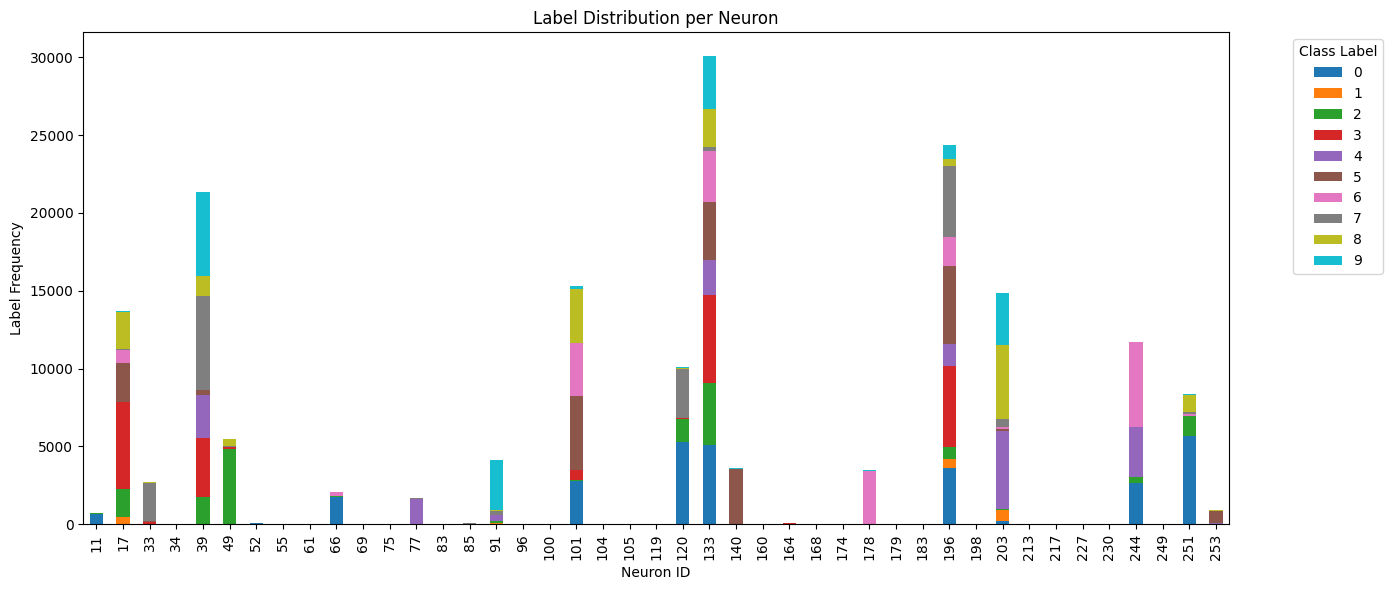

In [231]:
plot_df = merged_df.set_index('neuron_id')

label_columns = [str(i) for i in range(10)] if plot_df.columns[0] == '0' else list(range(10))
label_freqs = plot_df[label_columns]


label_freqs.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 6),
    colormap='tab10'
)

plt.xlabel("Neuron ID")
plt.ylabel("Label Frequency")
plt.title("Label Distribution per Neuron")
plt.legend(title="Class Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

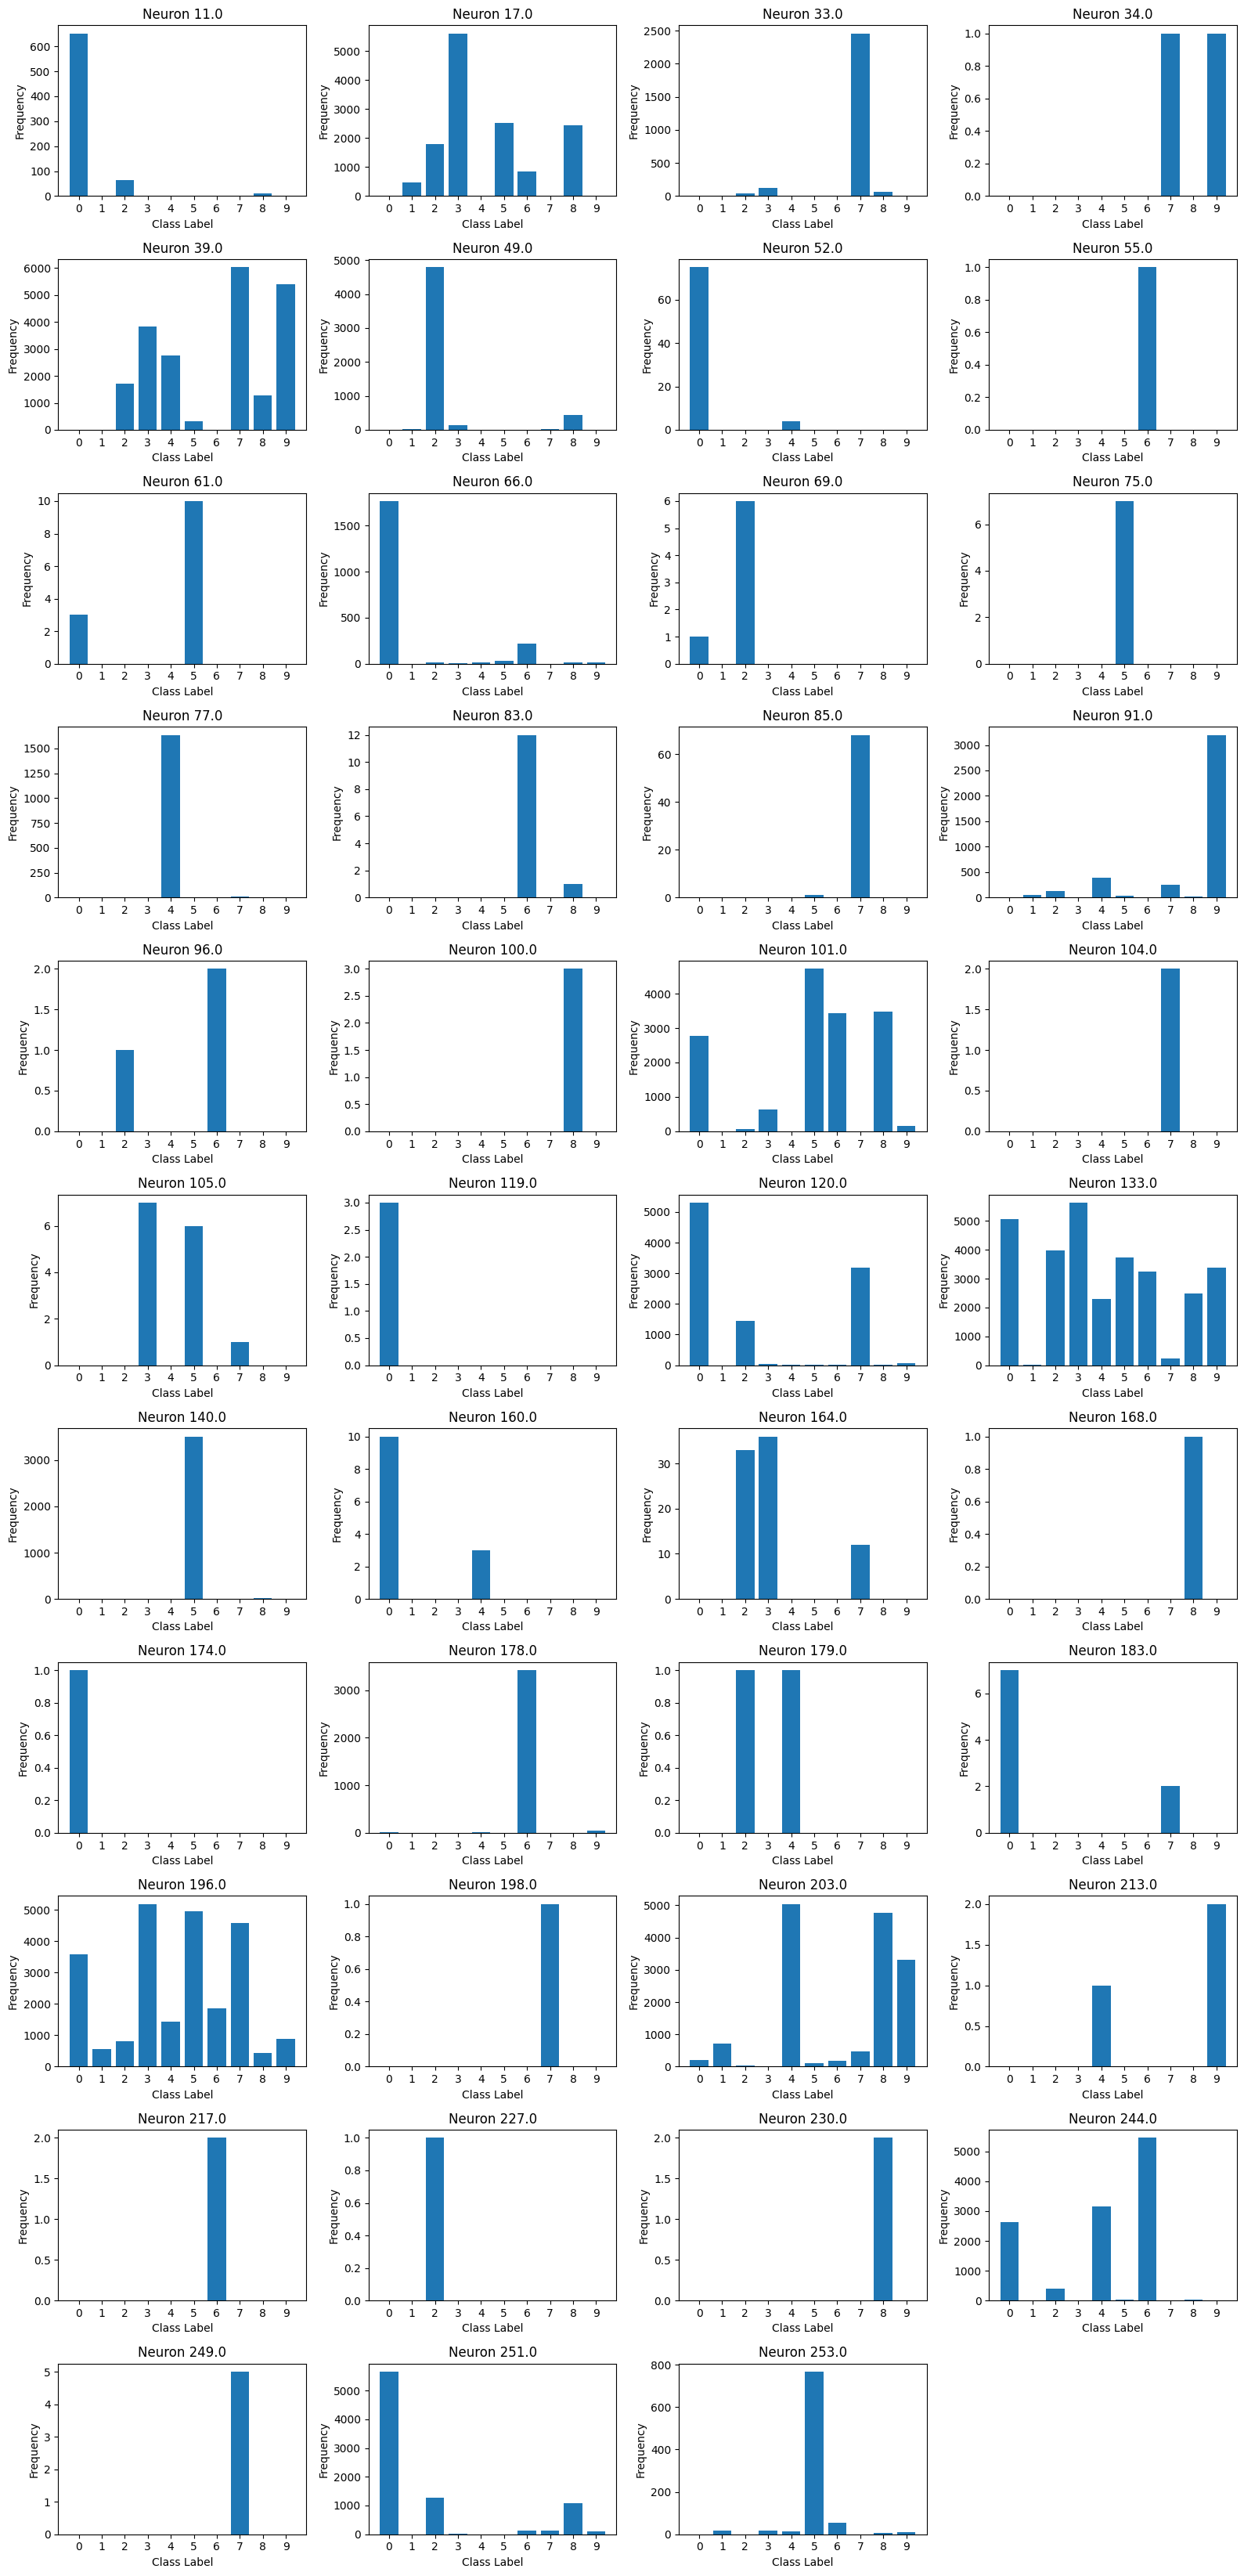

In [232]:
import matplotlib.pyplot as plt

n_neurons = merged_df.shape[0]

n_cols = 4
n_rows = (n_neurons + n_cols - 1) // n_cols  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))

axes = axes.flatten()

label_cols = list(range(10))  

for idx, row in merged_df.iterrows():
    neuron_id = row['neuron_id']
    label_counts = row[label_cols]

    ax = axes[idx]
    ax.bar(label_cols, label_counts)
    ax.set_title(f'Neuron {neuron_id}')
    ax.set_xticks(label_cols)
    ax.set_xlabel('Class Label')
    ax.set_ylabel('Frequency')

for ax in axes[n_neurons:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
